# Fastest Curve

Study time spent for a ball rolling on a inclined curve using simulations/calculations

height to width ratio = 1 : 2

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd drive/MyDrive/Fastest\ curve/

In [3]:
# %cd drive/MyDrive/Colab Notebooks/Fastest\ curve/

In [4]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ball
import curve
import motion
import params

## Func: simulation run

In [5]:
def run_simulation(params, motion, curve, motion_type='vel', xy0=None):
  hist = {}  # step: (t, x, y)

  if xy0 is None:
    x0 = 1e-8 * params.g
    y0 = curve.cal_height(x0)
  else:
    x0, y0 = xy0
  ball_ = ball.Ball(x0, y0)

  # Init
  step = 0
  t = 0
  ball_.update(curve, motion, 0., type=motion_type)  # init vel if needed
  hist[step] = (t, ball_.x, ball_.y)
  
  # Roll the ball
  while not ball_.check_goal(params.w):
    ball_.update(curve, motion, params.dt, type=motion_type)
    step += 1
    t += params.dt

    hist[step] = (t, ball_.x, ball_.y)

    if ball_.check_vxLT0():
      print(f'Warning: ball vel .lt. 0. Terminating simulation.')
      return None
  
  return t, hist

## Settings

In [6]:
folder_output = 'output-1-2/'
pars = dict(
  g=9.8,
  h=100,
  w=200,
  dt=0.001,
)
motion_types = ['vel-sim', 'acc-sim', 'vel-int']

In [7]:
import os
os.makedirs(folder_output, exist_ok=True)
params_ = params.Params(**pars)
motion_ = motion.MotionSimple(params_)

## Compare motion methods & curve params

3 motion methods:
- velocity simulation: solved from conservation of energy
- acceleration simulation: solved from force equations
- velocity integration: integral t using vel calculated above
   
Curve parameters are discussed in each cell

### Linear curve
$y = - x / w + h$

In [8]:
t_spent = {mt: [] for mt in motion_types}
curve_ = curve.CurveLinear(params_.h, params_.w)

# vel-simulation
t, _ = run_simulation(params_, motion_, curve_, motion_type='vel')
t_spent['vel-sim'].append(t)

# acc-simulation
t, _ = run_simulation(params_, motion_, curve_, motion_type='acc')
t_spent['acc-sim'].append(t)

# integral-based
t = motion_.cal_total_time_vel(None, curve_, 100000)
t_spent['vel-int'].append(t)

In [9]:
display(pd.DataFrame(t_spent))

,vel-sim,acc-sim,vel-int
0,10.107,10.102,10.078226


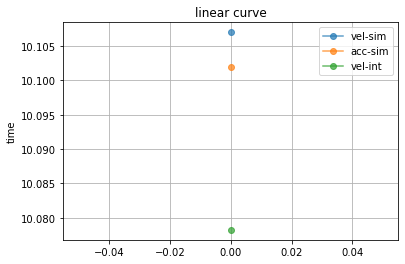

In [10]:
for label, x in t_spent.items():
  plt.plot(x, marker='o', label=label, alpha=0.7)
plt.title('linear curve')
plt.grid(); plt.xlabel(''); plt.ylabel('time')
plt.legend();
plt.show()

### Exponential curves

$y = A \cdot e^{-B \cdot x} + C$

In [11]:
Bs = (10 ** np.linspace(-1, 2, 16)) / pars['w']
Bs

array([0.0005    , 0.00079245, 0.00125594, 0.00199054, 0.00315479,
       0.005     , 0.00792447, 0.01255943, 0.01990536, 0.03154787,
       0.05      , 0.07924466, 0.12559432, 0.19905359, 0.31547867,
       0.5       ])

In [12]:
t_spent = {mt: [] for mt in motion_types}
for B in Bs:
  # Generate objects
  curve_ = curve.CurveExp.generate_from_B(B, params_.h, params_.w)
    
  # vel-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='vel')
  t_spent['vel-sim'].append(t)

  # acc-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='acc')
  t_spent['acc-sim'].append(t)

  # integral-based
  t = motion_.cal_total_time_vel(None, curve_, 100000)
  t_spent['vel-int'].append(t)

In [13]:
display(pd.DataFrame(t_spent, index=pd.Series(Bs, name='B')))

,vel-sim,acc-sim,vel-int
B,,,
0.000500,9.976,9.971,9.947467
0.000792,9.903,9.898,9.874239
0.001256,9.791,9.786,9.762947
0.001991,9.626,9.621,9.598081
0.003155,9.391,9.386,9.363961
0.005000,9.081,9.076,9.054324
0.007924,8.719,8.713,8.692110
0.012559,8.378,8.373,8.351374
0.019905,8.169,8.164,8.139614


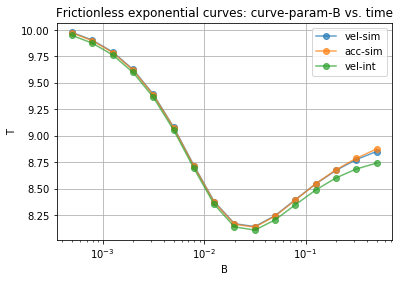

In [14]:
for method, x in t_spent.items():
  plt.xscale('log')
  plt.plot(Bs, x, marker='o', alpha=0.7, label=method)
plt.title('Frictionless exponential curves: curve-param-B vs. time')
plt.legend(); plt.grid()
plt.xlabel('B'); plt.ylabel('T')
plt.savefig(f'{folder_output}timeSpent_ExpCurve.png')
plt.show()

### Parabolic curves

$y = A x^2 + B x + C$

In [15]:
As = (10 ** np.linspace(-3, -1, 17))
As

array([0.001     , 0.00133352, 0.00177828, 0.00237137, 0.00316228,
       0.00421697, 0.00562341, 0.00749894, 0.01      , 0.01333521,
       0.01778279, 0.02371374, 0.03162278, 0.04216965, 0.05623413,
       0.07498942, 0.1       ])

In [16]:
t_spent = {mt: [] for mt in motion_types}
for A in As:
  # Generate objects
  curve_ = curve.CurveParabola.generate_from_A(A, params_.h, params_.w)
    
  # vel-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='vel')
  t_spent['vel-sim'].append(t)

  # acc-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='acc')
  t_spent['acc-sim'].append(t)

  # integral-based
  t = motion_.cal_total_time_vel(None, curve_, 100000)
  t_spent['vel-int'].append(t)

In [17]:
display(pd.DataFrame(t_spent, index=pd.Series(As, name='A')))

,vel-sim,acc-sim,vel-int
A,,,
0.001000,9.282,9.277,9.255382
0.001334,9.092,9.087,9.064929
0.001778,8.884,8.878,8.857013
0.002371,8.672,8.667,8.645601
0.003162,8.481,8.476,8.454334
0.004217,8.346,8.341,8.319080
0.005623,8.317,8.312,8.289162
0.007499,8.453,8.448,8.424469
0.010000,8.817,8.813,8.786928


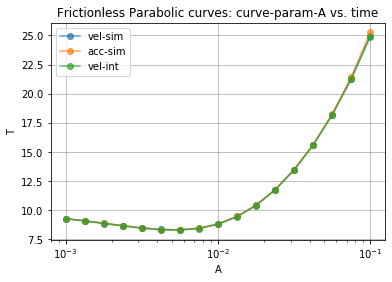

In [18]:
for method, x in t_spent.items():
  plt.xscale('log')
  plt.plot(As, x, marker='o', alpha=0.7, label=method)
plt.title('Frictionless Parabolic curves: curve-param-A vs. time')
plt.legend(); plt.grid()
plt.xlabel('A'); plt.ylabel('T')
plt.savefig(f'{folder_output}timeSpent_ParabolicCurve.png')
plt.show()

### Circular curves

$y = y_0 - \sqrt{R^2 - (x - x_0)^2}$

In [19]:
As = np.linspace(1, 3, 17) * params_.h / params_.w
As

array([0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    , 1.0625, 1.125 , 1.1875, 1.25  , 1.3125, 1.375 , 1.4375,
       1.5   ])

In [20]:
t_spent = {mt: [] for mt in motion_types}
for A in As:
  # Generate objects
  curve_ = curve.CurveCircle.generate_from_A(A, params_.h, params_.w)
    
  # vel-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='vel')
  t_spent['vel-sim'].append(t)

  # acc-simulation
  t, _ = run_simulation(params_, motion_, curve_, motion_type='acc')
  t_spent['acc-sim'].append(t)

  # integral-based
  t = motion_.cal_total_time_vel(None, curve_, 100000)
  t_spent['vel-int'].append(t)

In [21]:
display(pd.DataFrame(t_spent, index=pd.Series(As, name='A')))

,vel-sim,acc-sim,vel-int
A,,,
0.5000,8.284,8.321,7.980583
0.5625,8.253,8.250,8.180283
0.6250,8.206,8.202,8.151925
0.6875,8.170,8.166,8.124247
0.7500,8.144,8.140,8.102903
0.8125,8.126,8.122,8.088302
0.8750,8.115,8.111,8.079896
0.9375,8.111,8.106,8.076926
1.0000,8.111,8.107,8.078627


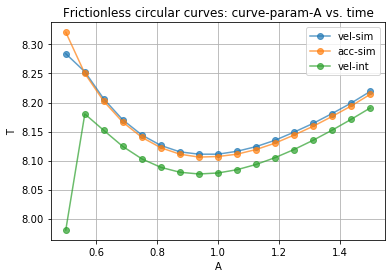

In [22]:
for method, x in t_spent.items():
  plt.plot(As, x, marker='o', alpha=0.7, label=method)
plt.title('Frictionless circular curves: curve-param-A vs. time')
plt.legend(); plt.grid()
plt.xlabel('A'); plt.ylabel('T')
plt.savefig(f'{folder_output}timeSpent_CircularCurve.png')
plt.show()

## Compare curves & mk .gif animation

- Run with acc-sim base

In [23]:
# Params
N_snapshots = 50

In [66]:
curves = {
    'linear': curve.CurveLinear(params_.h, params_.w),
    'exponential, B=3.15e-2': curve.CurveExp.generate_from_B(3.15e-2, params_.h, params_.w),
    'parabolic, A=5.62e-3': curve.CurveParabola.generate_from_A(5.62e-3, params_.h, params_.w),
    'circular (fastest), A=9.38e-1': curve.CurveCircle.generate_from_A(9.38e-1, params_.h, params_.w),
    'exponential, B=1.00e-1': curve.CurveExp.generate_from_B(1.00e-1, params_.h, params_.w),
    'exponential, B=8.00e-3': curve.CurveExp.generate_from_B(8.00e-3, params_.h, params_.w),
    'parabolic, A=2.00e-3': curve.CurveParabola.generate_from_A(2.00e-3, params_.h, params_.w),
}

In [67]:
max_step = 0
rolling_history = {}
for name, curve_ in curves.items():
  _, hist = run_simulation(params_, motion_, curve_, motion_type='acc')
  rolling_history[name] = hist
  max_step = max(max_step, max(hist.keys()))

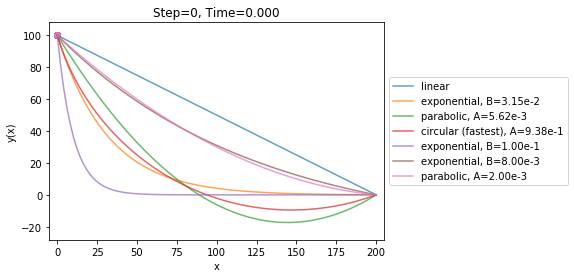

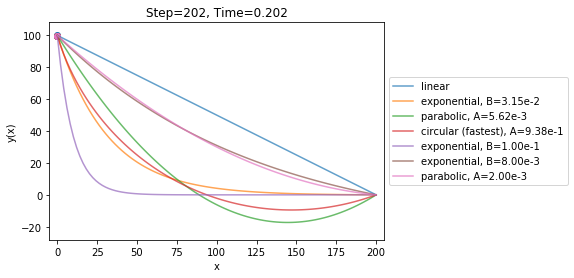

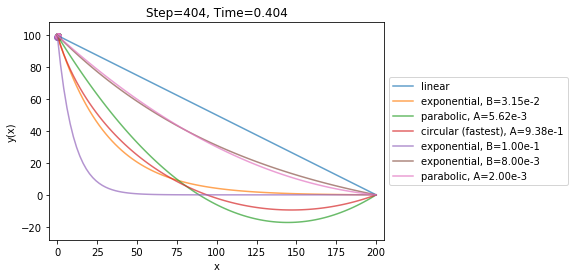

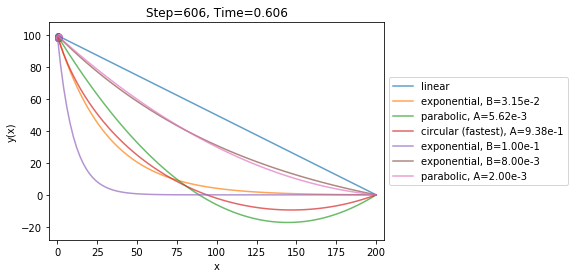

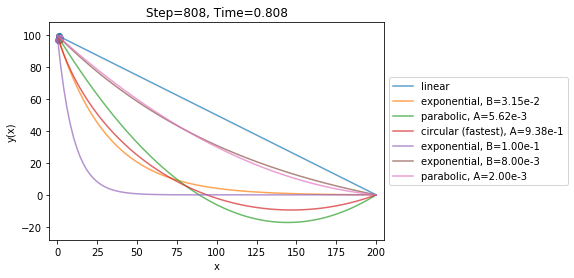

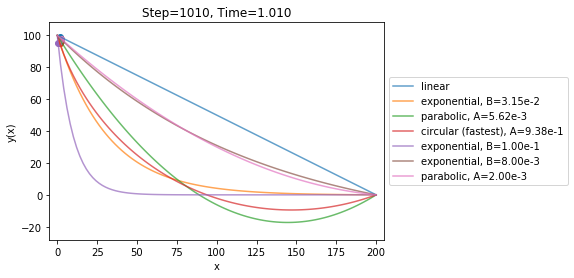

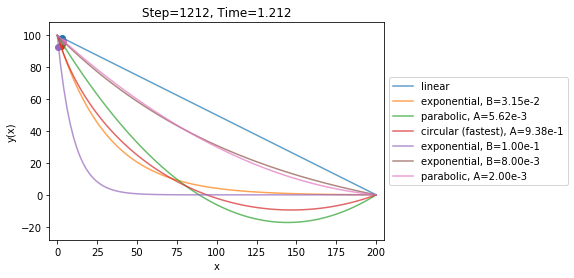

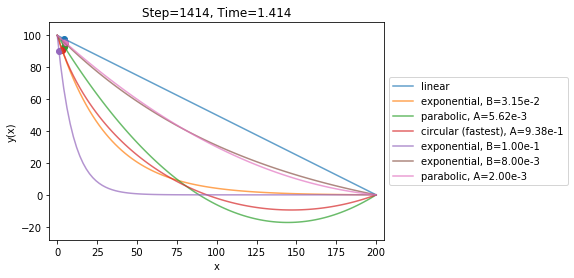

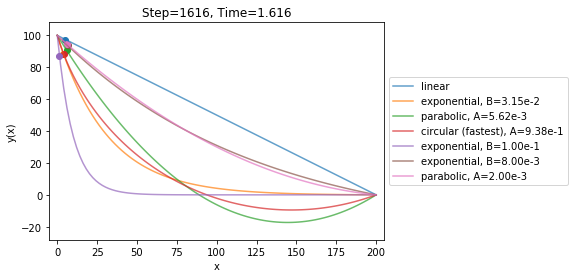

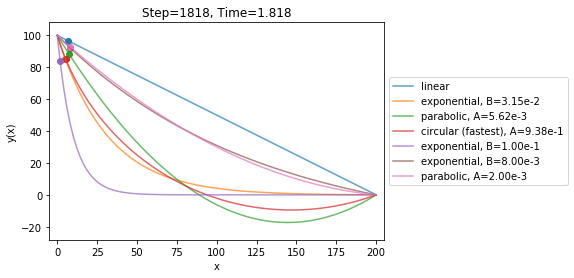

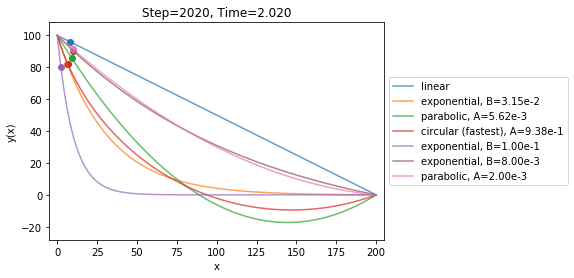

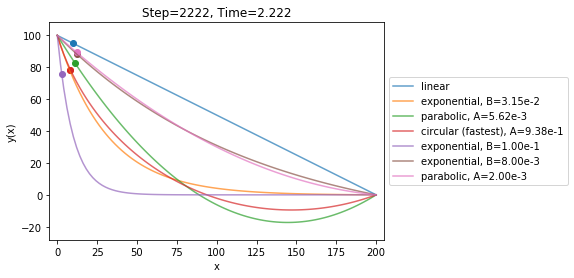

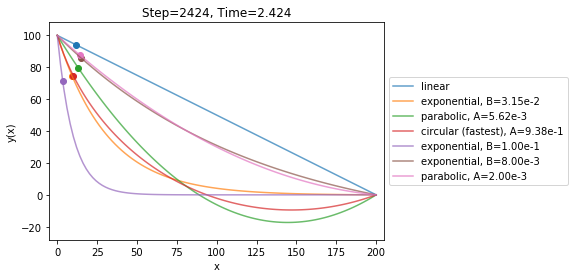

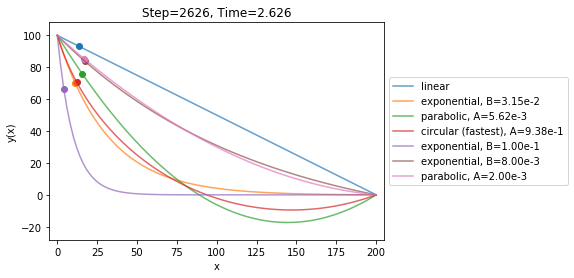

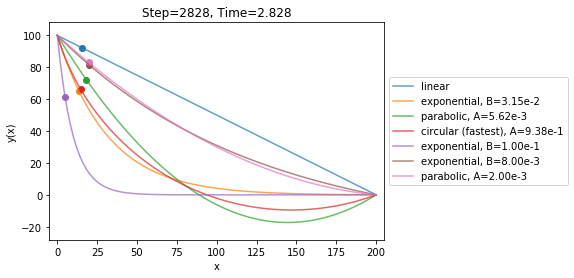

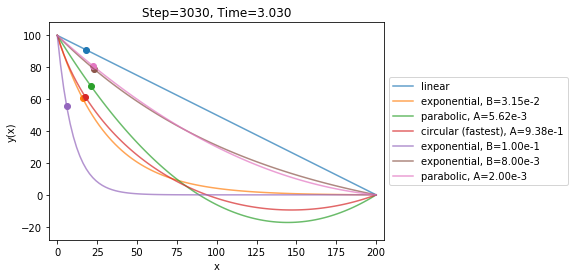

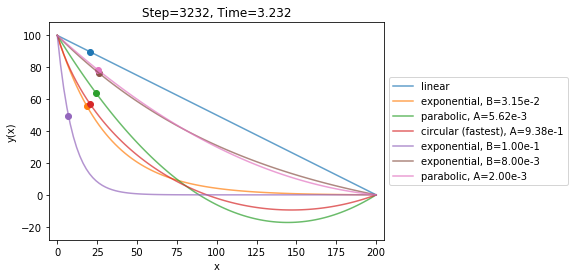

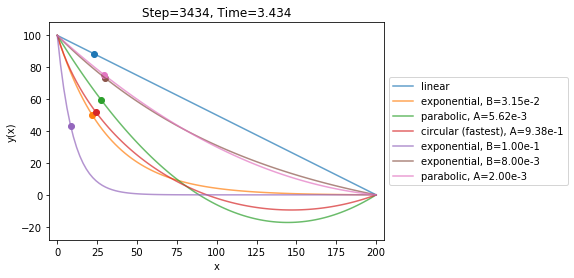

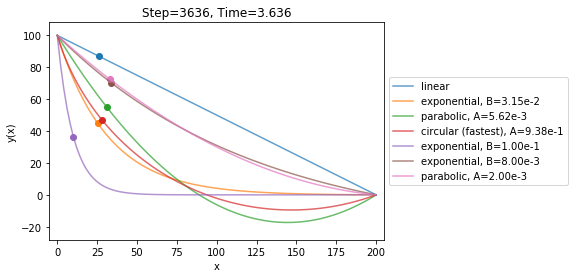

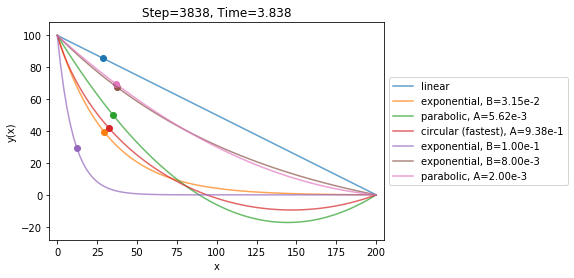

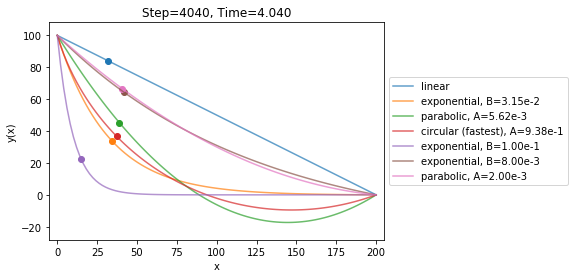

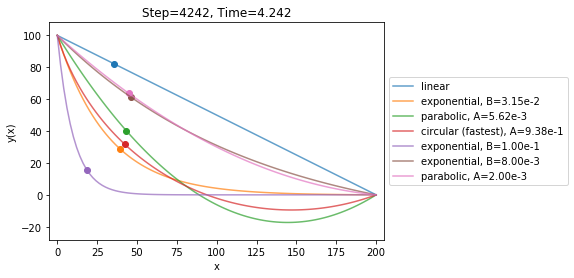

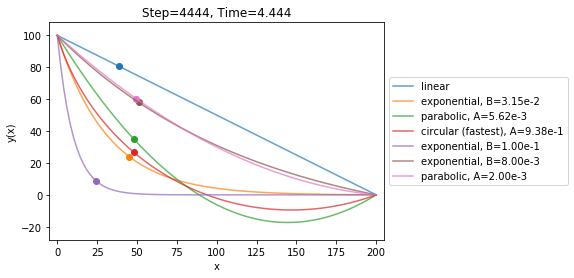

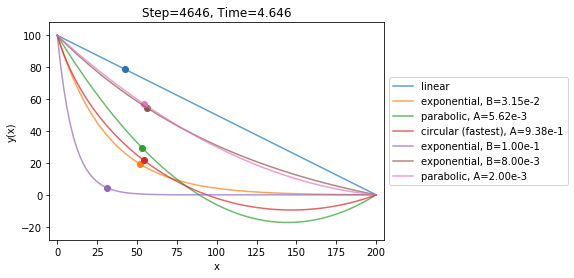

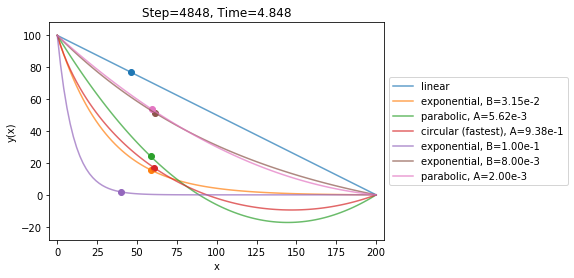

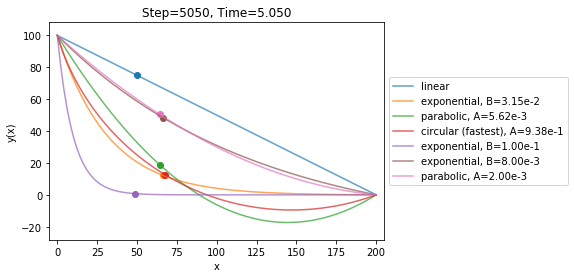

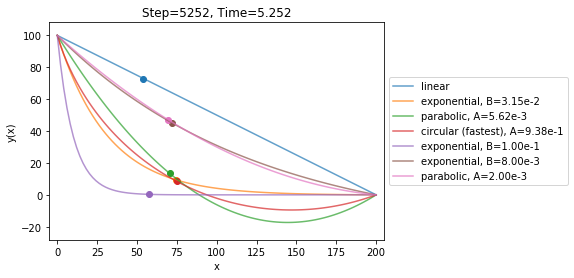

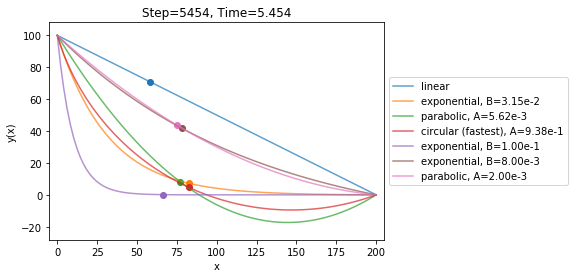

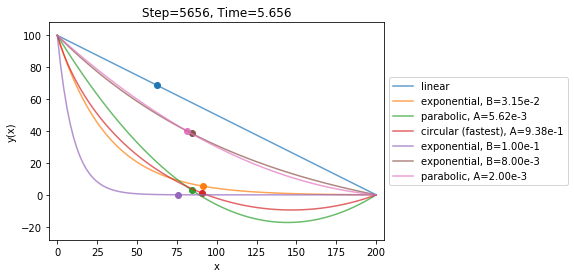

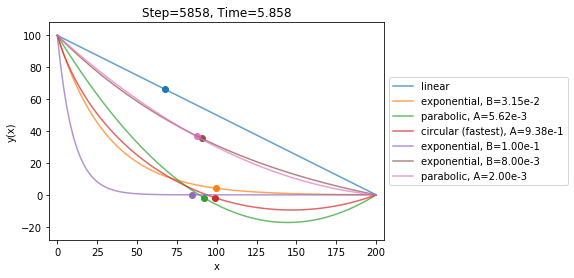

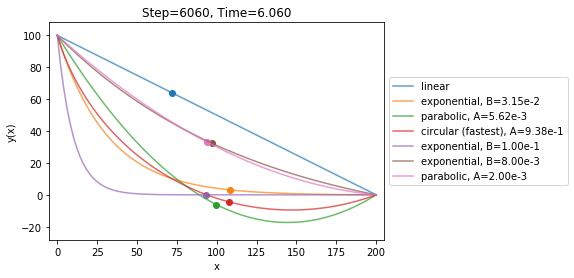

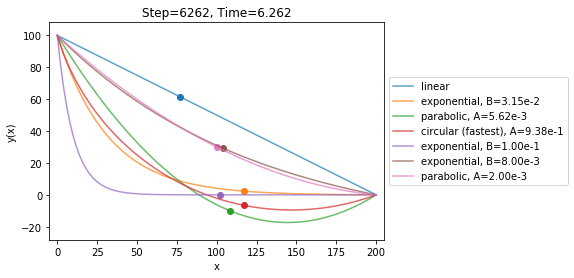

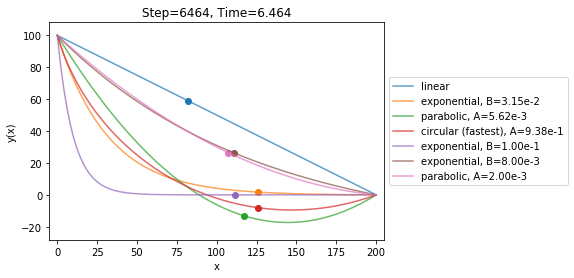

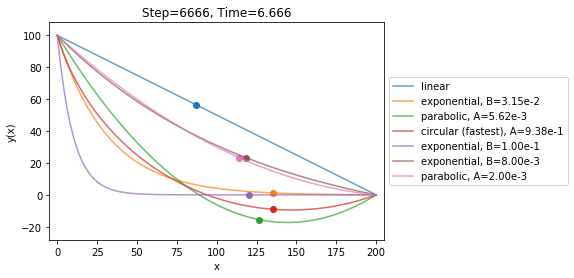

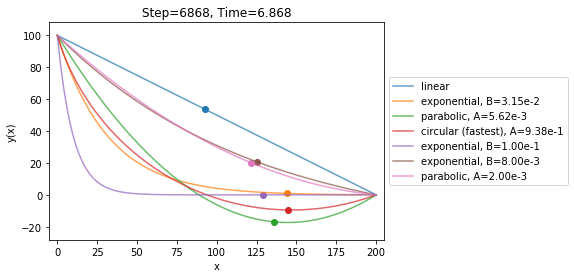

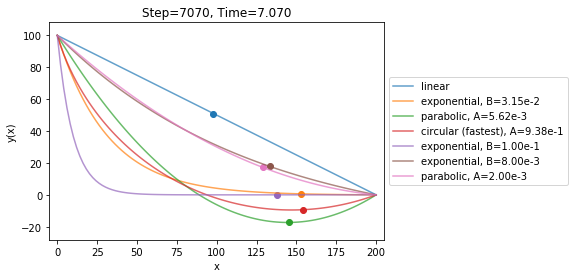

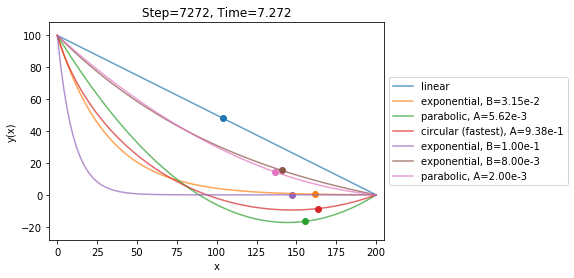

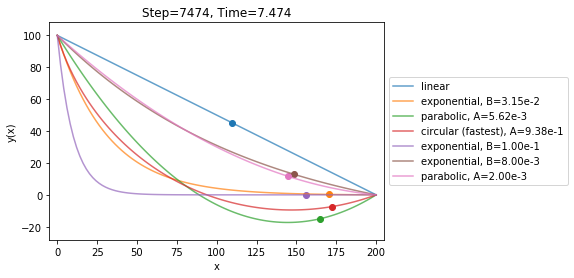

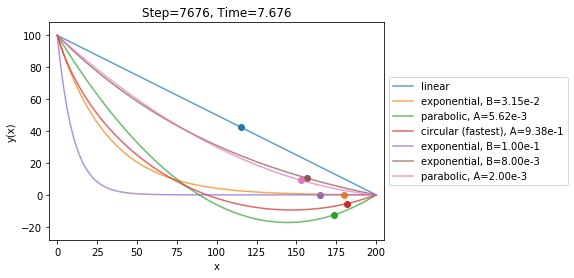

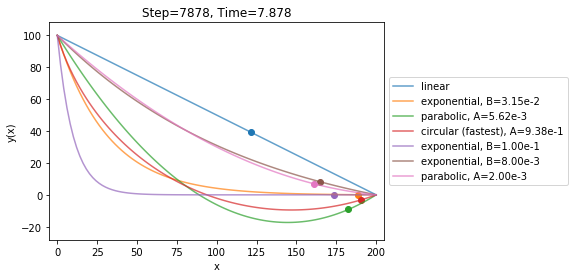

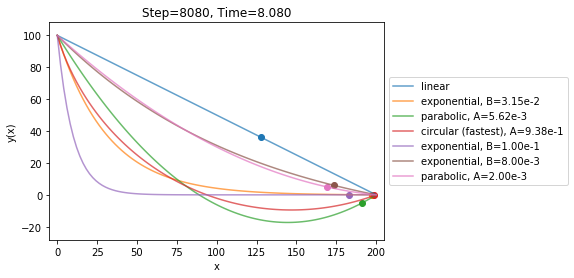

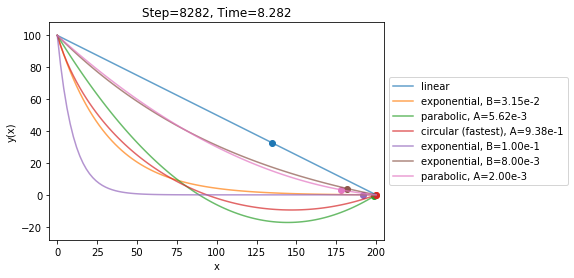

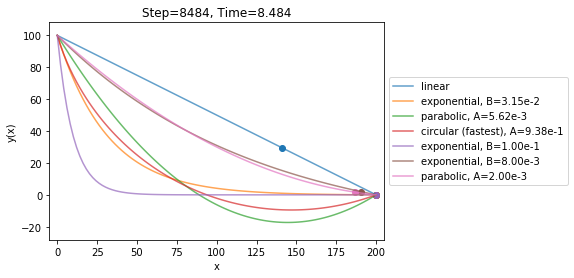

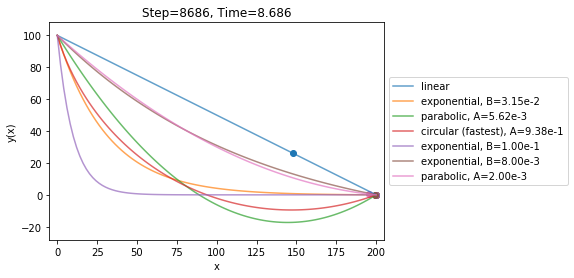

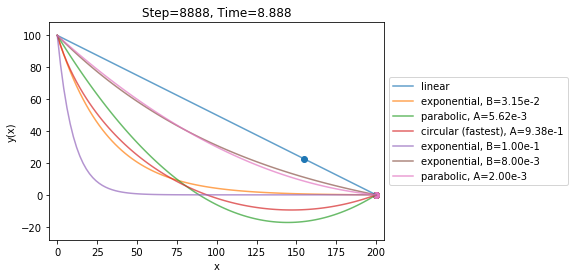

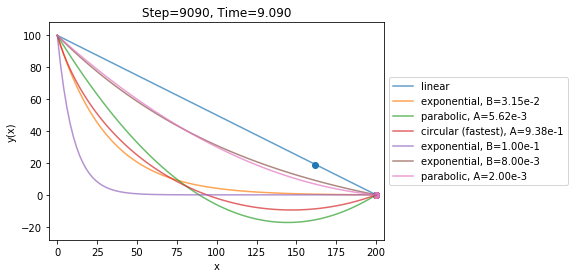

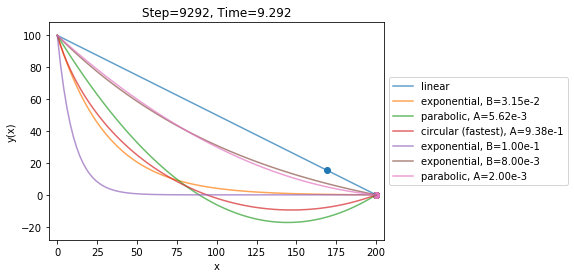

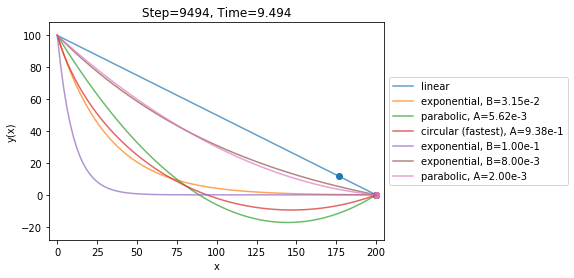

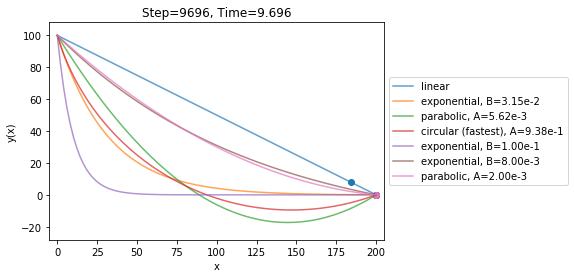

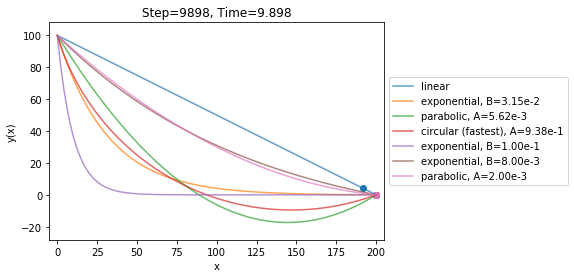

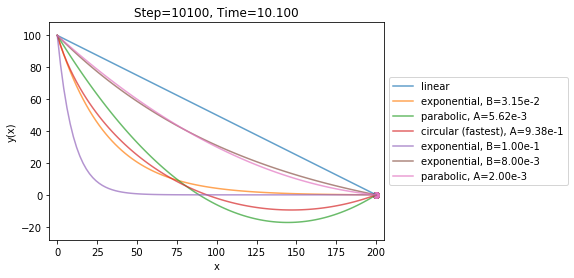

In [68]:
step_snapshot = int(np.ceil(max_step // N_snapshots))
os.makedirs(f'{folder_output}snapshots/', exist_ok=True)

for step in range(0, max_step, step_snapshot):
  for name, hist in rolling_history.items():
    curve_ = curves[name]
    curve_.plot(label=f'{name}', alpha=0.7)

    if step in hist:
      t, x, y = hist[step]
    else:
      x, y = params_.w, 0
    
    plt.scatter(x, y)
  
  plt.title(f'Step={step}, Time={t:.3f}')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.axis('equal')
  plt.xlim(-5, 205)
  plt.ylim(-25, 105)
  plt.savefig(f'{folder_output}snapshots/{step:04d}.png', bbox_inches='tight')
  plt.show()

In [69]:
with imageio.get_writer(
    f'{folder_output}/ball_rolling.gif', mode='I', duration=0.2,
  ) as writer:
  for step in range(0, max_step, step_snapshot):
    filename = f'{folder_output}snapshots/{step:04d}.png'
    image = imageio.imread(filename)
    writer.append_data(image)